## オープンデータの活用(自転車盗難推測)
長野県自転車盗難データを推測する。

In [1]:
import numpy as np
import scipy as sc
from scipy import linalg
from scipy import spatial
import scipy.spatial.distance
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pylab
trans_data = pd.read_csv("./CSV/output/transform_bohan_data.csv")
trans_data

Unnamed: 0  occurTime  age  occupation  isRock  occurMonth
0              0         13   10           1       1           7
1              1          6   10           2       1           9
2              2         12   10           2       1          10
3              3         13   10           2       1          12
4              4          7   10           2       1           6
...          ...        ...  ...         ...     ...         ...
1476        1491         10   10           1       0           6
1477        1492          6   50           4       0           6
1478        1493         17   10           2       0           7
1479        1494         16   10           2       0           8
1480        1495          8   10           2       0          11

[1481 rows x 6 columns]

In [2]:
# 任意の情報を末尾に追加
userInfo = pd.Series([1496, 15, 60, 5, 1, 1], index=trans_data.columns)
trans_data = trans_data.append( userInfo, ignore_index=True )

In [3]:
# 不要な列 Unnamed: 0の削除
trans_data = trans_data.drop(columns='Unnamed: 0')
trans_data

occurTime  age  occupation  isRock  occurMonth
0            13   10           1       1           7
1             6   10           2       1           9
2            12   10           2       1          10
3            13   10           2       1          12
4             7   10           2       1           6
...         ...  ...         ...     ...         ...
1477          6   50           4       0           6
1478         17   10           2       0           7
1479         16   10           2       0           8
1480          8   10           2       0          11
1481         15   60           5       1           1

[1482 rows x 5 columns]

In [4]:
# 任意情報追加の場合は1482
ROW = 1482
COLUMN = 5

In [5]:
# row:行,column:列,ave:平均,vcm:分散共分散行列
row = []
column = []
ave = [0.0 for i in range(COLUMN)]
vcm = np.zeros((ROW, COLUMN, COLUMN))
diff = np.zeros((1, COLUMN))
mahal = np.zeros(ROW)
tmp = np.zeros(COLUMN)

In [6]:
# rowにtrans_dataの行要素(1481件分)を代入
for i in range(ROW):
    row.append(list(trans_data.iloc[i]))
print(len(row))

1482


In [7]:
# rowにtrans_dataの列要素(5件分)を代入
for i in range(COLUMN):
    column.append(list(trans_data.iloc[:, i]))
print(len(column))

5


In [8]:
# 平均ベクトルの計算
# 平均値の計算 (各特徴量の平均値を算出) 
for i in range(COLUMN):
    ave[i] = np.average(column[i])
print(ave)

[12.950742240215924, 19.898785425101213, 2.8157894736842106, 0.27800269905533065, 6.922402159244265]


In [9]:
# 分散共分散行列の計算

# Numpyのメソッドを使うので，array()でリストを変換した．
row = np.array([row])
ave = np.array(ave)

# 分散共分散行列を求める
# np.swapaxes()で軸を変換することができる．
for i in range(ROW):
    diff = (row[0][i] - ave)
    diff = np.array([diff])
    vcm[i] = (diff * np.swapaxes(diff, 0, 1)) / ROW

print(row[0][1481])
print(ave)
print(vcm[1481])

[15 60  5  1  1]
[12.95074224 19.89878543  2.81578947  0.2780027   6.92240216]
[[ 2.83364195e-03  5.54505568e-02  3.02024991e-03  9.98352612e-04
  -8.18929054e-03]
 [ 5.54505568e-02  1.08509272e+00  5.91022233e-02  1.95364161e-02
  -1.60253387e-01]
 [ 3.02024991e-03  5.91022233e-02  3.21914684e-03  1.06409859e-03
  -8.72859186e-03]
 [ 9.98352612e-04  1.95364161e-02  1.06409859e-03  3.51740960e-04
  -2.88526206e-03]
 [-8.18929054e-03 -1.60253387e-01 -8.72859186e-03 -2.88526206e-03
   2.36672384e-02]]


In [10]:
# マハラノビス距離
# mahalnobis distanceを求める
for i in range(ROW):
    # 一般逆行列を生成し，計算の都合上転値をかける
    vcm[i] = sc.linalg.pinv(vcm[i])
    vcm[i] = vcm[i].transpose()
    vcm[i] = np.identity(COLUMN)
    # 差分ベクトルの生成
    diff = (row[0][i] - ave)
    for j in range(COLUMN):
        tmp[j] = np.dot(diff, vcm[i][j])
    mahal[i] = np.dot(tmp, diff)

mahal [10.09023152 12.32079445 10.46653069 ... 10.44930337 11.82647047
 40.65309054]


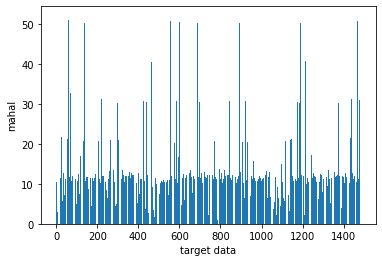

In [11]:
plot = pylab.arange(0.0, ROW, 1.0)
mahal = np.sqrt(mahal)

print("mahal", mahal)
plt.bar(range(ROW),mahal)
plt.xlabel("target data")
plt.ylabel("mahal")
plt.savefig("mahal.png")

In [12]:
# 最後これにマハラノビス距離の列を追加したい
trans_data["mahal"] = mahal
# マハラノビス距離を追加したデータをcsv出力
trans_data.to_csv('./CSV/output/mahl_bohan_data.csv')

In [13]:
# 高齢者が多い
trans_data[trans_data["mahal"] >= 35] 

occurTime  age  occupation  isRock  occurMonth      mahal
10           18   60           4       1           8  40.455992
49           10   60           4       1          10  40.351078
60           21   70           4       1          11  50.926149
64           15   60           4       1           3  40.368499
68           12   60           4       1           1  40.571046
...         ...  ...         ...     ...         ...        ...
1456          9   60           4       0           5  40.359522
1458         17   60           4       0           7  40.323561
1467         18   70           4       0           1  50.716676
1474         19   70           4       0           6  50.488174
1481         15   60           5       1           1  40.653091

[79 rows x 6 columns]

In [14]:
# 若者が多い
trans_data[trans_data["mahal"] <= 16.0] 

occurTime  age  occupation  isRock  occurMonth      mahal
0            13   10           1       1           7  10.090232
1             6   10           2       1           9  12.320794
2            12   10           2       1          10  10.466531
3            13   10           2       1          12  11.178424
4             7   10           2       1           6  11.637650
...         ...  ...         ...     ...         ...        ...
1475         18   10           1       0           6  11.300715
1476         10   10           1       0           6  10.531763
1478         17   10           2       0           7  10.729924
1479         16   10           2       0           8  10.449303
1480          8   10           2       0          11  11.826470

[1230 rows x 6 columns]